In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jinja2
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [2]:
df = pd.read_csv('card_transdata.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


In [3]:
df1 = df.copy(deep=True)
df1.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [4]:
numerical = [var for var in df1.columns if df1[var].dtype!='O']
print('There are {} numerical variables\n'.format(len(numerical)))
if len(numerical)>1:
    print('The numerical variables :', numerical)

There are 8 numerical variables

The numerical variables : ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'repeat_retailer', 'used_chip', 'used_pin_number', 'online_order', 'fraud']


array([[<AxesSubplot: title={'center': 'distance_from_home'}>,
        <AxesSubplot: title={'center': 'distance_from_last_transaction'}>,
        <AxesSubplot: title={'center': 'ratio_to_median_purchase_price'}>],
       [<AxesSubplot: title={'center': 'repeat_retailer'}>,
        <AxesSubplot: title={'center': 'used_chip'}>,
        <AxesSubplot: title={'center': 'used_pin_number'}>],
       [<AxesSubplot: title={'center': 'online_order'}>,
        <AxesSubplot: title={'center': 'fraud'}>, <AxesSubplot: >]],
      dtype=object)

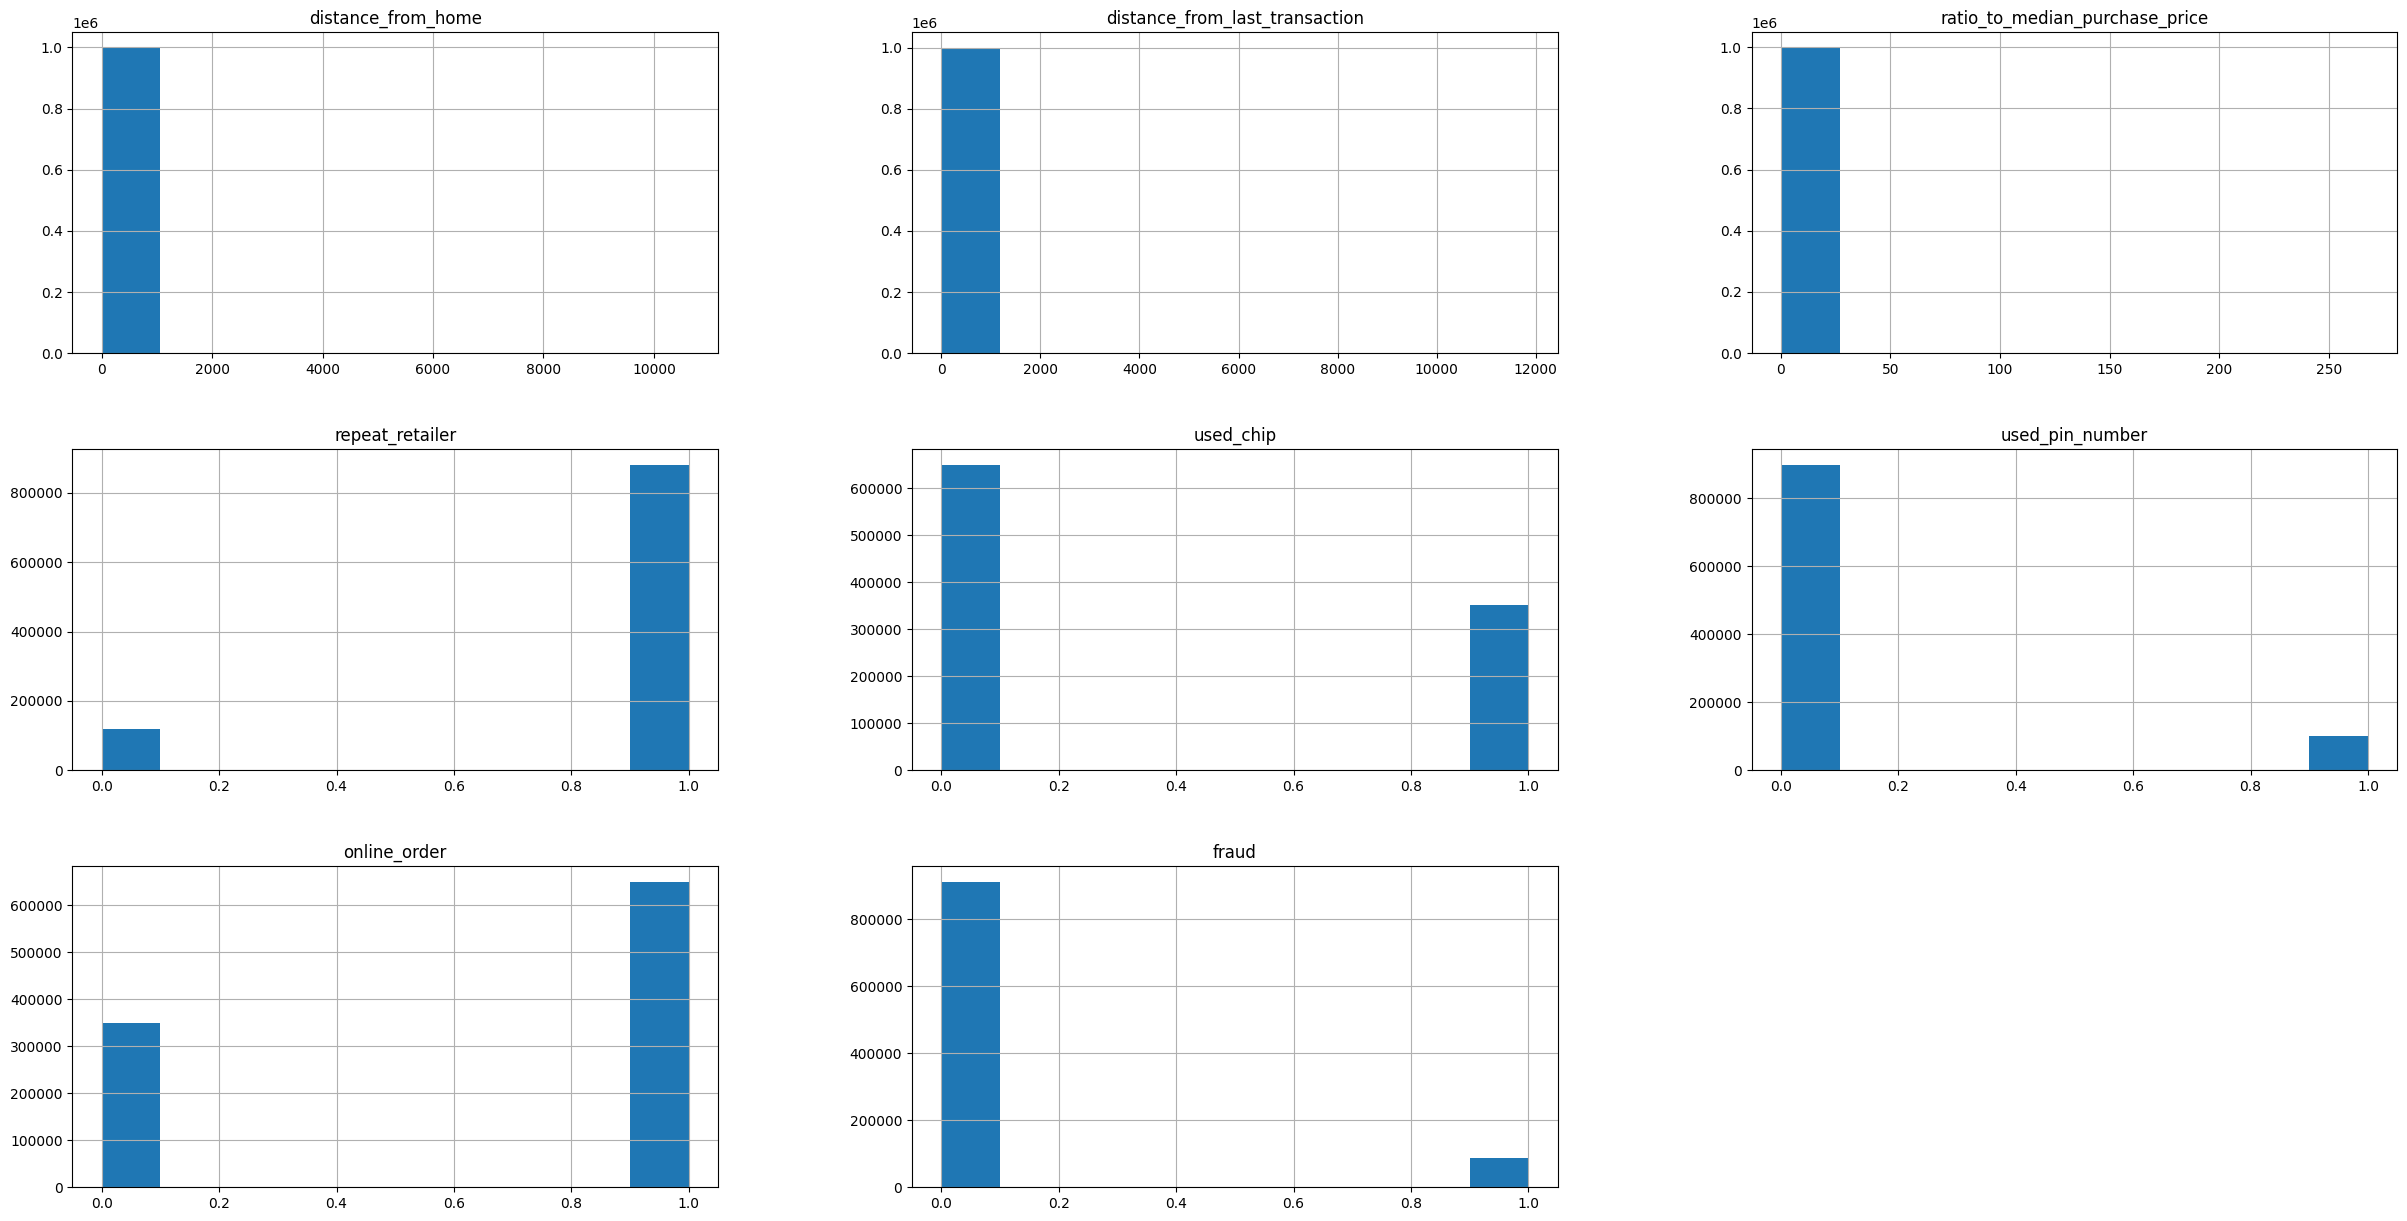

In [5]:
df1[numerical].hist(figsize=(30,15))

In [6]:
df1.fraud.value_counts()

0.0    912597
1.0     87403
Name: fraud, dtype: int64

Class imbalance exists

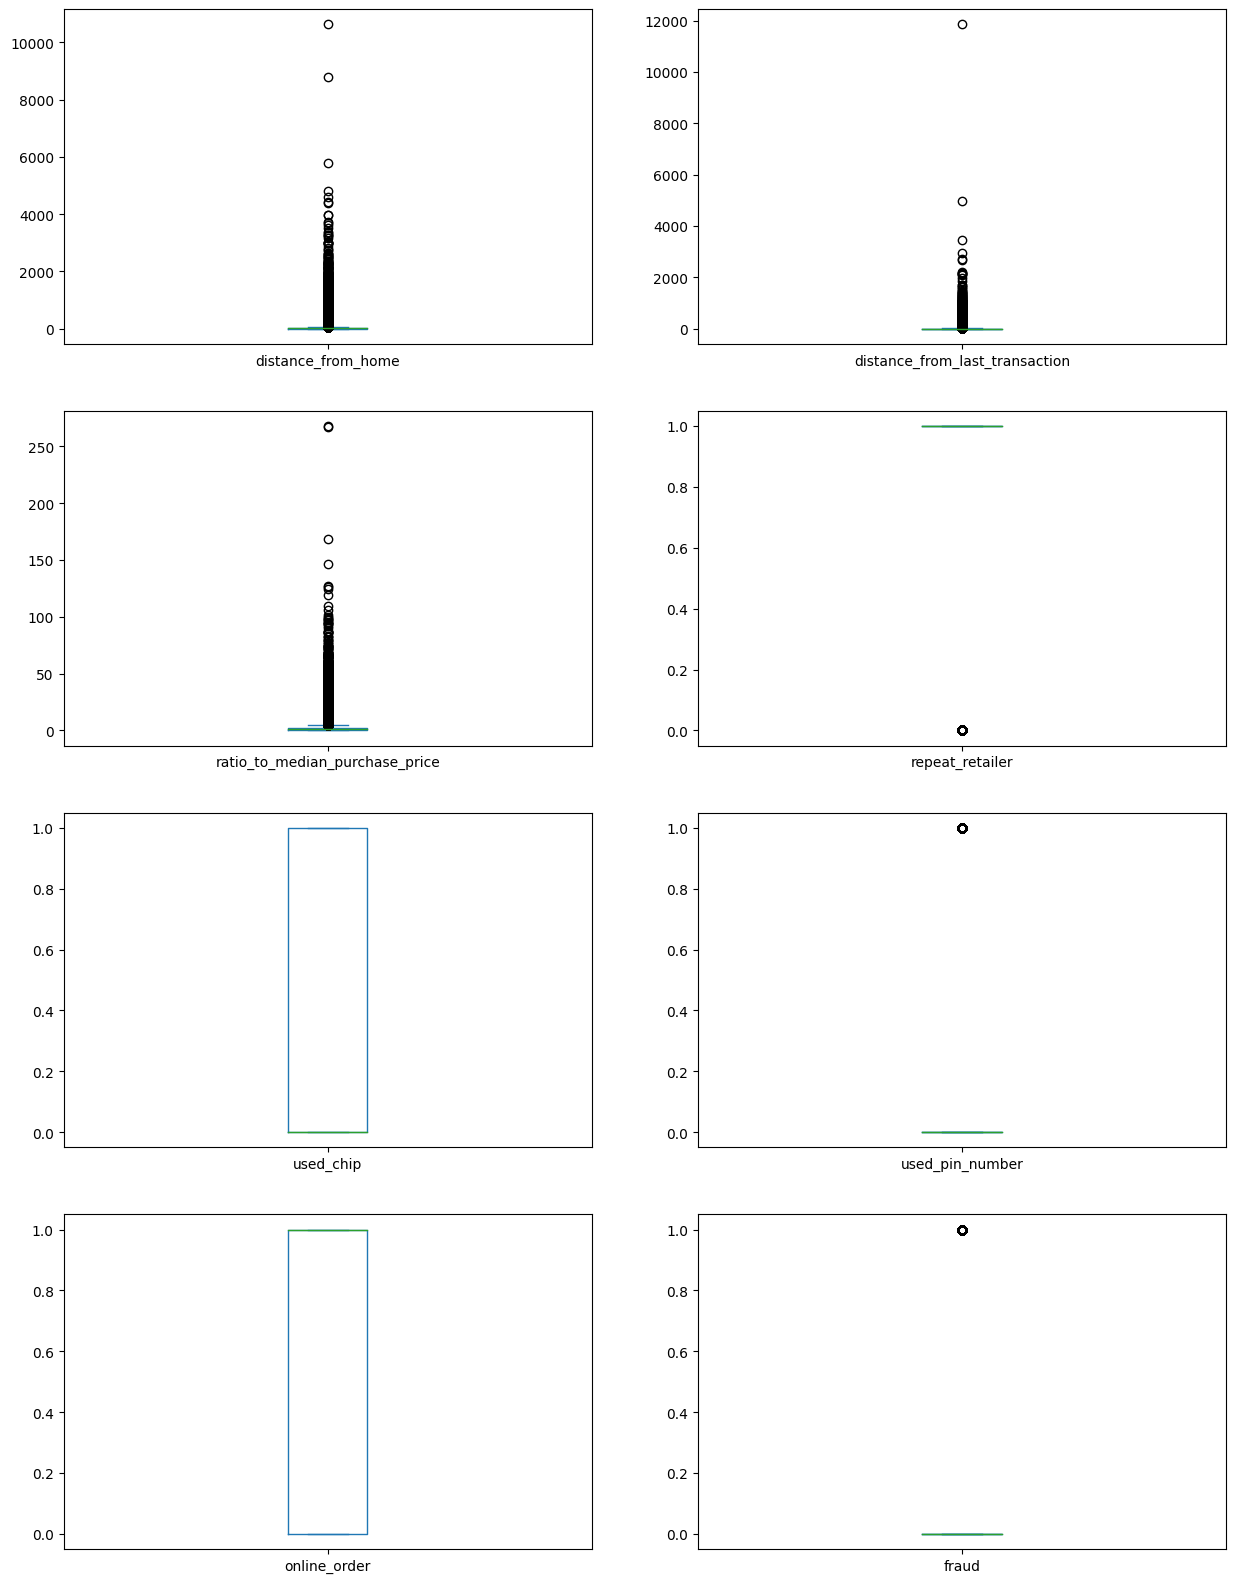

In [9]:
df1[numerical].plot(kind = "box",subplots = True,layout = (4,2),figsize=(15,20)) #Boxplot to check the outliers
plt.show()

In [8]:
numerical

['distance_from_home',
 'distance_from_last_transaction',
 'ratio_to_median_purchase_price',
 'repeat_retailer',
 'used_chip',
 'used_pin_number',
 'online_order',
 'fraud']

In [10]:
rem_list =['distance_from_home',
 'distance_from_last_transaction',
 'ratio_to_median_purchase_price']

In [11]:
#Using the InterQuartile Range to fill the values
def remove_outlier(i , col):
    Q1 = i[col].quantile(0.25)
    Q3 = i[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    df1[col] = np.clip(i[col] , lower_whisker , upper_whisker)
    return i

def treat_outliers_all(df , col_list):
    for c in col_list:
        i = remove_outlier(df , c)
    return i

In [12]:
df3 = treat_outliers_all(df1 , rem_list)

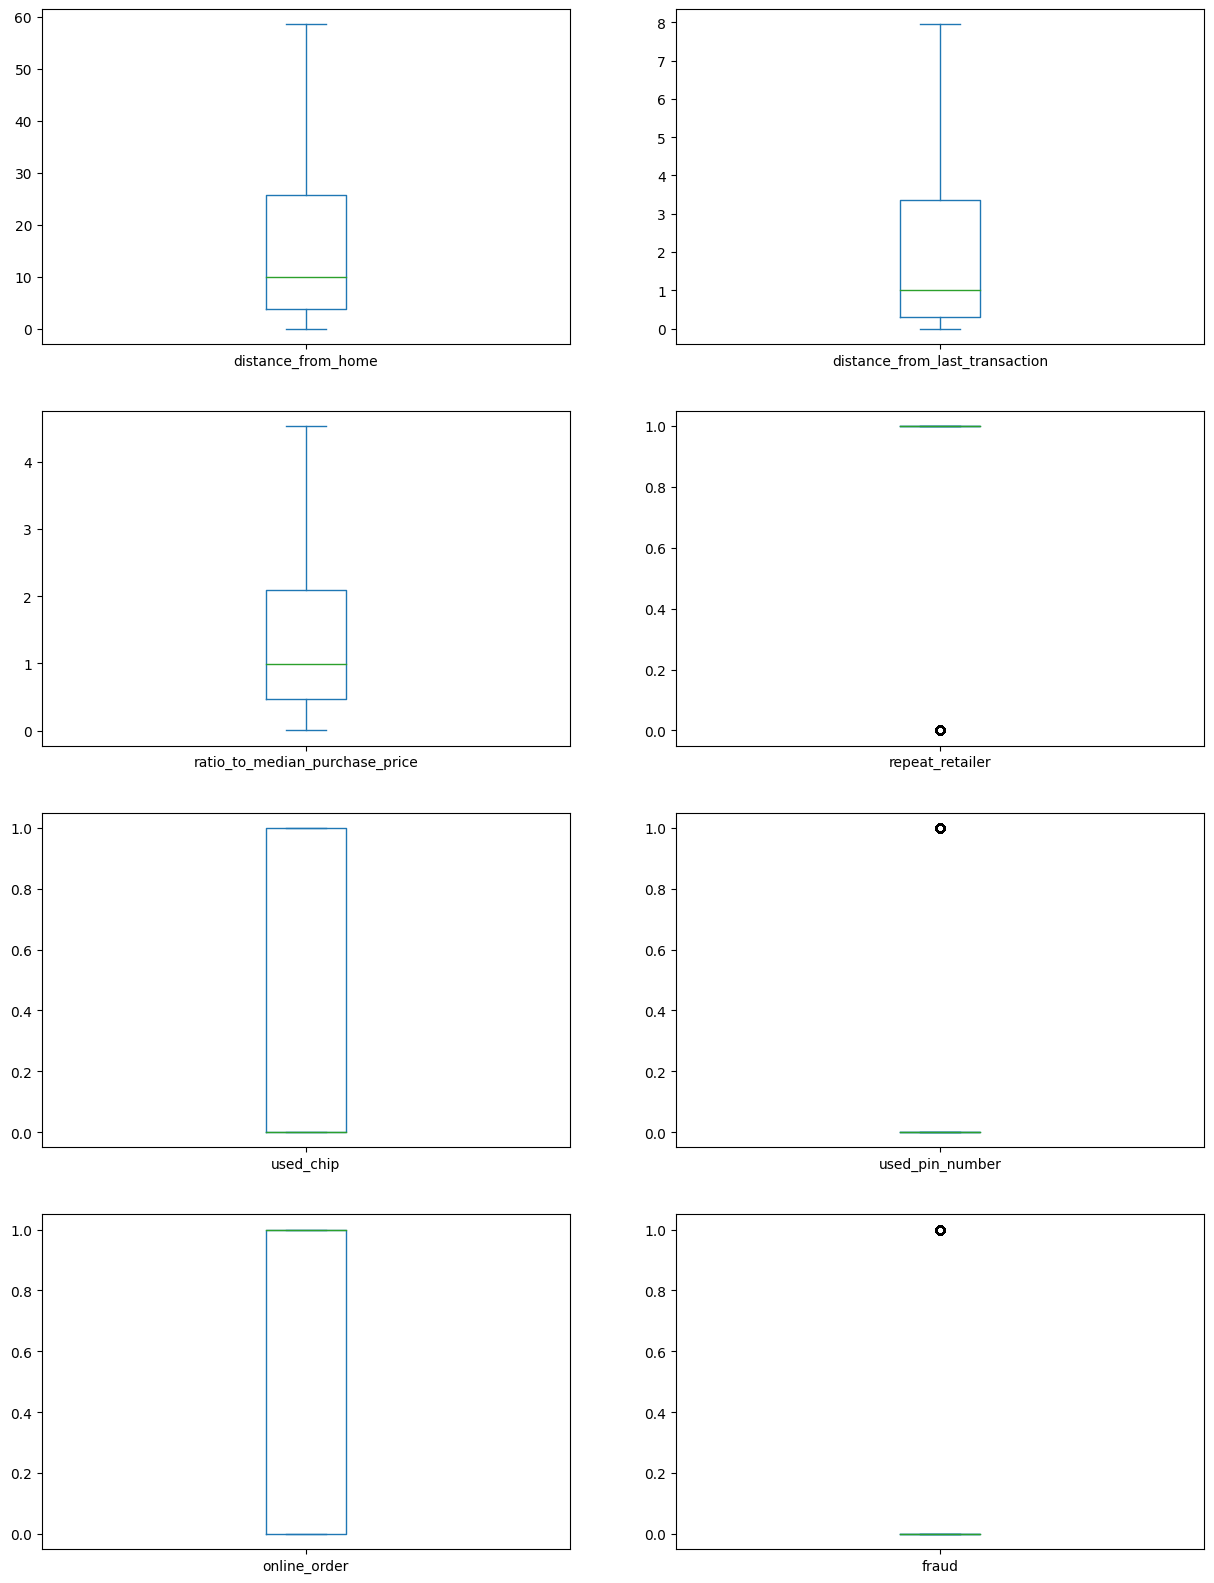

In [13]:
df3[numerical].plot(kind = "box",subplots = True,layout = (4,2),figsize=(15,20)) #Boxplot to check the outliers
plt.show()

In [14]:
df3.shape

(1000000, 8)

Feature Engineering

In [15]:
X = df3.drop(['fraud'],axis=1)
y = df3.fraud

X.shape, y.shape

((1000000, 7), (1000000,))

smote because there is huge imbalance

In [16]:
from imblearn.over_sampling import SMOTE

In [17]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [18]:
y.value_counts()

0.0    912597
1.0    912597
Name: fraud, dtype: int64

In [20]:
# create X and Y datasets for training
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,stratify=y, random_state=42, test_size = 0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1460155, 7), (365039, 7), (1460155,), (365039,))

In [21]:
from sklearn.preprocessing import MinMaxScaler

cols = X_train.columns
scaler = MinMaxScaler()
X_train_RF = scaler.fit_transform(X_train)
X_test_RF = scaler.transform(X_test)

X_train_RF = pd.DataFrame(X_train_RF,columns=cols)
X_test_RF = pd.DataFrame(X_test_RF,columns=cols)

In [22]:
from sklearn.linear_model import LogisticRegression


# instantiate the model
logreg = LogisticRegression(solver='liblinear', random_state=0)


# fit the model
logreg.fit(X_train_RF, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [23]:
print('Training set score: {:.4f}'.format(logreg.score(X_train_RF, y_train)))

print('Test set score: {:.4f}'.format(logreg.score(X_test_RF, y_test)))

Training set score: 0.9040
Test set score: 0.9044


In [24]:
y_pred = logreg.predict(X_test_RF)

In [25]:
log_accuracy = logreg.score(X_test_RF, y_test)
log_accuracy

0.904385558803306

In [29]:
# precision
log_pre = precision_score(y_test, y_pred)
log_pre

0.8933070446552276

In [30]:
# recall
log_rec = recall_score(y_test, y_pred)
log_rec

0.9184687621562687

KNN

In [31]:
from math import sqrt
print(sqrt(X_train.shape[1]))

2.6457513110645907


In [34]:
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
#In case of classifier like knn the parameter to be tuned is n_neighbors
param_grid = {'n_neighbors':np.arange(1,10)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,verbose=10,cv=6)
knn_cv.fit(X_train,y_train)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Fitting 6 folds for each of 9 candidates, totalling 54 fits
[CV 1/6; 1/9] START n_neighbors=1...............................................
[CV 1/6; 1/9] END ................n_neighbors=1;, score=0.972 total time=  17.8s
[CV 2/6; 1/9] START n_neighbors=1...............................................
[CV 2/6; 1/9] END ................n_neighbors=1;, score=0.972 total time=  15.5s
[CV 3/6; 1/9] START n_neighbors=1...............................................
[CV 3/6; 1/9] END ................n_neighbors=1;, score=0.972 total time=  15.3s
[CV 4/6; 1/9] START n_neighbors=1...............................................
[CV 4/6; 1/9] END ................n_neighbors=1;, score=0.973 total time=  15.4s
[CV 5/6; 1/9] START n_neighbors=1...............................................
[CV 5/6; 1/9] END ................n_neighbors=1;, score=0.972 total time=  15.3s
[CV 6/6; 1/9] START n_neighbors=1...............................................
[CV 6/6; 1/9] END ................n_neighbors=1;,

In [35]:
print('Training set score: {:.4f}'.format(knn_cv.best_estimator_.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(knn_cv.best_estimator_.score(X_test, y_test)))

Training set score: 0.9840
Test set score: 0.9735


In [36]:
y_pred = knn_cv.predict(X_test)

In [37]:
knn_accuracy = knn_cv.score(X_test, y_test)
knn_accuracy

0.9735233769542433

In [38]:
# precision
knn_pre = precision_score(y_test, y_pred)
knn_pre

0.9608309428086976

In [39]:
# recall
knn_rec = recall_score(y_test, y_pred)
knn_rec

0.987294473452079

Random Forests

In [40]:
# import Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# instantiate the classifier 
rfc = RandomForestClassifier(random_state=12,n_estimators=10)

# fit the model
rfc.fit(X_train_RF, y_train)

# Predict the Test set results
y_pred = rfc.predict(X_test_RF)

# Check accuracy score 
from sklearn.metrics import accuracy_score

print('Model accuracy score with 10 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 10 decision-trees : 0.9709


In [41]:
print('Training set score: {:.4f}'.format(rfc.score(X_train_RF, y_train)))

print('Test set score: {:.4f}'.format(rfc.score(X_test_RF, y_test)))

Training set score: 0.9981
Test set score: 0.9709


In [42]:
# import Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# instantiate the classifier 
rfc_100 = RandomForestClassifier(random_state=12,n_estimators=100)

# fit the model
rfc_100.fit(X_train_RF, y_train)

# Predict the Test set results
y_pred = rfc_100.predict(X_test_RF)

# Check accuracy score 
from sklearn.metrics import accuracy_score

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 100 decision-trees : 0.9721


In [43]:
print('Training set score: {:.4f}'.format(rfc_100.score(X_train_RF, y_train)))

print('Test set score: {:.4f}'.format(rfc_100.score(X_test_RF, y_test)))

Training set score: 0.9999
Test set score: 0.9721
